In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_cal_helper as cal
import binary_image_helper as binar
import lane_polynomial_helper as lane
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# 1- Get object points

In [2]:
#Get object points (same for all images)
nx=9
ny=6
obj=cal.object_points(nx,ny)

#Create the image points and object points list
img_points=[]
obj_points=[]

for fname in glob.glob('camera_cal/calibration*.jpg'):
    #Read image
    img=cv2.imread(fname)
    #Find image points
    ret, corners = cal.find_corners_chessbooard(img,nx,ny,0)
    #Add points to list
    if ret:
        img_points.append(corners)
        obj_points.append(obj)

# 2- Define functions

## 2.1- Functions 

In [3]:
def find_line_pixels(img, nwindows, margin, minpix):
    '''Calculates the pixels corresponding to the lane'''
    # Find the peak of the bottom half of the image
    # These are be the starting point for the line
    sum_pix = np.sum(img[img.shape[0]//2:,:], axis=0)
    x_current = np.argmax(sum_pix)
    # Set height of windows - based on nwindows and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Lists to receive lane pixel indices
    lane_inds = []
    # Loop through the windows
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
        # Append these indices to the lists
        lane_inds.append(good_inds)
        #If you found more than minpix pixels, recenter next window on their mean position
        if len(good_inds)>minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        lane_inds = np.concatenate(lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    pixels_x = nonzerox[lane_inds]
    pixels_y = nonzeroy[lane_inds]
    return pixels_x, pixels_y

def line_around_poly(img, polyfit):
    
    # Margin around the previous polynomial to search
    margin = 100
    
    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of the polynomial function
    lane_inds = ((nonzerox > (polyfit[0]*(nonzeroy**2) + polyfit[1]*nonzeroy + polyfit[2] - margin)) & (nonzerox < (polyfit[0]*(nonzeroy**2) + polyfit[1]*nonzeroy + polyfit[2] + margin)))
    
    # Extract left and right line pixel positions
    pixels_x = nonzerox[lane_inds]
    pixels_y = nonzeroy[lane_inds]    
    return pixels_x, pixels_y


## 2.2- Class line

In [4]:
class Line():
    def __init__(self, nwindows, margin, minpix, xm_per_pix, ym_per_pix):
        ## Initiate main parameters for the functions
        #number of sliding windows
        self.nwindows = nwindows
        #width of the windows(+/- margin)
        self.margin = margin
        #minimum number of pixels found to recenter window
        self.minpix = minpix
        #meters per pixel in x and y direction
        self.ym = ym_per_pix
        self.xm = xm_per_pix
        
        ## Initiate characteristics of the line
        #Does the line exist already
        self.exists = False
        #Polynomal fit coefficients
        self.polyfit = None
        #List of last 5 polynomial fits
        self.fitlist = []
        #Average polynomial fit (based on list)
        self.avefit = None        
        #Line polynomial
        self.poly = None
        #Radius of curvature
        self.curverad = None
        #Dist to zero
        self.dist = None
        #Previous wrong lines
        self.wrong = 0        
        ###TEST
        self.px = None
        self.py = None
        ###TEST
         
    def new_line(self, top_binary_image):
        '''The image corresponds only to half image (left or right)'''
        if self.exists:
            self.update_line(top_binary_image)                   
        else:
            self.init_line(top_binary_image)
        return
    
    def init_line(self, top_binary_image):
        #Update exists         
        self.exists = True
        #Calculate lane pixels
        pixels_x, pixels_y = find_line_pixels(top_binary_image, self.nwindows, self.margin, self.minpix)
        ##TEST
        self.px, self.py = find_line_pixels(top_binary_image, self.nwindows, self.margin, self.minpix)
        if pixels_x.size == 0 or pixels_y.size == 0:
            self.exists = False
            return
        ##TEST
        #Calculate polynomial coefficients
        self.polyfit = np.polyfit(pixels_y, pixels_x, 2)
        #Calculate fitlist
        self.fitlist.append(self.polyfit)
        ##TEST
        if len(self.fitlist)>5:
                del self.fitlist[0]
        ##TEST
        #Calculate avefit
        self.avefit = self.calc_average(self.fitlist)
        #Caculate rest of parameters
        self.calculate_parameters(top_binary_image.shape)
        return
    
    def update_line(self, top_binary_image):
        ## Calculate parameters
        #Calculate lane pixels
        pixels_x, pixels_y = line_around_poly(top_binary_image, self.polyfit)
        ##TEST
        self.px, self.py = line_around_poly(top_binary_image, self.avefit) #TEST
        if pixels_x.size == 0 or pixels_y.size == 0:
            self.exists = False
            return
        #if self.wrong > 4:
        #    self.reinit_line()
        #    self.new_line(top_binary_image)
        #if pixels_x.size == 0 or pixels_y.size == 0:
        #    pixels_x = np.array([top_binary_image.shape[1]//2, top_binary_image.shape[1]//2])
        #    pixels_y = np.array([top_binary_image.shape[0], 0])
        #    self.wrong = 5
        ##TEST
        #Polynomial coefficients
        polyfit = np.polyfit(pixels_y, pixels_x, 2) 
        #Poynomial        
        ploty = np.linspace(0, top_binary_image.shape[0]-1, top_binary_image.shape[0])
        polynomial = polyfit[0]*ploty**2 + polyfit[1]*ploty + polyfit[2]
        #Curve radious
        curverad = self.calc_radious(polyfit, ploty)
        #Distance to zero
        dist = [polynomial[top_binary_image.shape[0]-1], polynomial[0]]
        ## Sanity check
        if self.check_line(curverad, dist):
            self.wrong = 0
            #Save parameters
            self.polyfit = polyfit
            self.fitlist.append(polyfit)
            if len(self.fitlist)>5:
                del self.fitlist[0]      
            self.avefit = self.calc_average(self.fitlist)
            #Caculate rest of parameters
            self.calculate_parameters(top_binary_image.shape)
        else:
            self.wrong += 1
            #print('Skip line')
            if self.wrong > 4:
                ##TEST
                #self.reinit_line()
                #self.new_line(top_binary_image)
                self.wrong = 0
                self.init_line(top_binary_image)
                ##TEST
                #print('Reinitialize line')
        return
    ##TEST
    '''
    def reinit_line(self):
        ## Initiate characteristics of the line
        #Does the line exist already
        self.exists = False
        #Polynomal fit coefficients
        self.polyfit = None
        #List of last 5 polynomial fits
        self.fitlist = []
        #Average polynomial fit (based on list)
        self.avefit = None
        #Line polynomial
        self.poly = None
        #Radius of curvature
        self.curverad = None
        #Dist to zero
        self.dist = None
        #Previous wrong lines
        self.wrong = 0       
        ###TEST
        self.px = None
        self.py = None
        ###TEST
        return
        '''
    ##TEST
    
    def check_line(self, curverad, dist):
        error_c = 150 #m
        error_d = 0.2/self.xm #=0.2 m 
        status = True
        #Check radious
        if np.abs(curverad - self.curverad) > error_c:
            #print('Cuverad out of boundaries. Error: {} m'.format(int(curverad-self.curverad)))
            status = False
        elif np.abs(dist[0] - self.dist[0]) > error_d or np.abs(dist[1] - self.dist[1]) > error_d:
            #Check radious
            #print('Dist out of boundaries. Error: {} pix'.format(int(dist-self.dist)))
            status = False
        return status
            
    def calc_average(self, p_list):
        M = np.array(p_list)
        average = np.mean(M, axis=0)
        return average
    
    def calc_radious(self, polyfit, ploty):
        A = polyfit[0]*self.xm/self.ym**2
        B = polyfit[1]*self.xm/self.ym
        y_eval = np.max(ploty)*self.ym
        curverad = ((1+(2*A*y_eval+B)**2)**1.5)/np.absolute(2*A)
        return curverad
    
    def line_returned(self, top_binary_image):
        if len(self.fitlist) < 2 or self.wrong > 4:
            ##TEST
            #self.reinit_line()
            #self.new_line(top_binary_image)
            ##TEST
            self.wrong = 0
            self.init_line(top_binary_image)
        else:
            self.wrong += 1
            ##TEST
            self.retrieve_line(top_binary_image)
            ##TEST
            #prev_fitlist = self.fitlist[0:-1]
            #prev_avefit = self.calc_average(prev_fitlist)
            #if (self.polyfit[0]*prev_avefit[0]) < 0 or (self.polyfit[1]*prev_avefit[1]) < 0:
            #    self.fitlist = prev_fitlist
            #    self.avefit = prev_avefit
            #    self.calculate_parameters(top_binary_image.shape)
        return None
    
    def retrieve_line(self, top_binary_image): 
        self.fitlist[-1] = self.fitlist[-2]
        self.avefit = self.calc_average(self.fitlist)
        self.calculate_parameters(top_binary_image.shape)
        return None
        
    
    def calculate_parameters(self, image_shape):
        #Calculate polynomial
        ploty = np.linspace(0, image_shape[0]-1, image_shape[0])
        self.poly = self.avefit[0]*ploty**2 + self.avefit[1]*ploty + self.avefit[2]
        #Calculate radious
        self.curverad = self.calc_radious(self.avefit, ploty)
        #Calculate distance
        self.dist = [self.poly[image_shape[0]-1], self.poly[0]]
        return

# 3- Create pipeline

In [8]:
def binary_image(image):
    '''Isolates the lines very well. Have problems to find the discuontinouos lines'''
    binary_S = binar.HLS_threshold(image, channel='S', thresh=(150, 255))
    R_channel=image[:,:,0]
    binary_R = np.zeros_like(R_channel)
    binary_R[R_channel > 210] = 1
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dir_binary= binar.dir_sobel(gray, sobel_kernel=9, thresh=(0.8, 1.2))
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S_channel=image_HLS[:,:,2]
    abs_binary_S=binar.abs_sobel(S_channel, orient='x', sobel_kernel=7, thresh=(50, 100))
    combined = np.zeros_like(binary_R)
    combined[((binary_R == 1) & (binary_S == 1))] = 1
    return combined

def alt_binary_image(image):
    '''Finds the lines, but adding a lot of noise'''
    binary_S = binar.HLS_threshold(image, channel='S', thresh=(150, 255))
    R_channel=image[:,:,0]
    binary_R = np.zeros_like(R_channel)
    binary_R[R_channel > 210] = 1
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dir_binary= binar.dir_sobel(gray, sobel_kernel=9, thresh=(0.8, 1.2))
    x_binary=binar.abs_sobel(gray, orient='x', sobel_kernel=9, thresh=(30, 150))
    combined = np.zeros_like(binary_R)
    combined[((binary_R == 1) & (binary_S == 1)) | ((x_binary == 1) & (dir_binary == 1))] = 1
    return combined

def check_curvature(polyfit_right, polyfit_left):
    wrong = False
    if (polyfit_right[0]*polyfit_left[0]) < 0 or (polyfit_right[1]*polyfit_left[1]) < 0:
        wrong = True
    return wrong

def check_distance(distance_top, distance_bottom):
    error_d = 1 #m
    wrong = False
    if distance_top < 0 or distance_bottom < 0 or np.abs(distance_top - distance_bottom) > error_d:
        wrong = True
    return wrong

def pipeline(image):
    #Undistort image
    undistorted = cal.cal_undistort(image, obj_points, img_points)
    #Create binary image
    binary = binary_image(undistorted)
    #Make perspective transform
    top_img = cal.pers_transform(binary, x_offlow, x_offhigh)
    ##TEST
    #plt.imshow(top_img, cmap='gray')
    #cal.compare_images(top_img, binary, 0, None, 'GRAY', 'GRAY')
    ##TEST
    #Split image vertically in 2
    midpoint = top_img.shape[1]//2
    left_top = top_img[:, :midpoint]
    ##TEST
    #plt.imshow(left_top, cmap='gray')
    ##TEST
    right_top = top_img[:, midpoint:]
    #Update line parameters
    right_line.new_line(right_top)
    left_line.new_line(left_top)
    ##TEST
    #Check if both lines exist (if one doesn't change binary image)
    if not left_line.exists:
        binary_2 = alt_binary_image(undistorted)
        top_img_2 = cal.pers_transform(binary_2, x_offlow, x_offhigh)
        left_top = top_img_2[:, :midpoint]
        left_line.new_line(left_top)
        ##TEST
        #plt.imshow(top_img, cmap='gray')
        #cal.compare_images(top_img_2, binary_2, 0, None, 'GRAY', 'GRAY')
        ##TEST
        if not left_line.exists:
            # Use previous polyfit
            left_line.retrieve_line(left_top)
            
    if not right_line.exists:
        binary_2 = alt_binary_image(undistorted)
        top_img_2 = cal.pers_transform(binary_2, x_offlow, x_offhigh)
        right_top = top_img_2[:, midpoint:]
        right_line.new_line(right_top)
        ##TEST
        #plt.imshow(top_img, cmap='gray')
        #cal.compare_images(top_img_2, binary_2, 0, None, 'GRAY', 'GRAY')
        ##TEST
        if not right_line.exists:
            # Use previous polyfit
            right_line.retrieve_line(right_top)
    
    ##TEST
    '''
    if left_line.exists & right_line.exists:
        #Calculate lines distance
        dist_top = (midpoint + right_line.dist[1] - left_line.dist[1])*xm_per_pix
        dist_bottom = (midpoint + right_line.dist[0] - left_line.dist[0])*xm_per_pix
        #Check lines 
        ##TEST
        #text3='Ok'
        ##TEST
        if check_curvature(right_line.avefit, left_line.avefit) or check_distance(dist_top, dist_bottom):
            #Check both lines
            right_line.line_returned(right_top)
            left_line.line_returned(left_top)
            ##TEST
            #text3='Not Ok'
            ##TEST
        #Extract information
        left_fitx = left_line.poly
        right_fitx = right_line.poly + midpoint
        left_curverad = left_line.curverad
        right_curverad = right_line.curverad
        dist_center = xm_per_pix*(midpoint - left_line.dist[0] - right_line.dist[0])/2
    elif not left_line.exists and right_line.exists:
        # Create left line paralell to right lane
        right_fitx = right_line.poly + midpoint
        left_fitx = right_fitx - 520 #assumed to be the distance between lanes
        right_curverad = right_line.curverad
        left_curverad = right_curverad
        dist_center = xm_per_pix*(midpoint - right_line.dist[0] - 260)
    elif left_line.exists and not right_line.exists:
        # Create right line paralell to left lane
        left_fitx = left_line.poly
        right_fitx = left_fitx + 520 #assumed to be the distance between lanes
        left_curverad = left_line.curverad
        right_curverad = left_curverad
        dist_center = xm_per_pix*(midpoint - left_line.dist[0] - 260)
    else:
        result_image = image
        cv2.putText(image, 'No line detected', (300,50), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
        return result_image'''
    ##TEST
        
    #Calculate lines distance
    dist_top = (midpoint + right_line.dist[1] - left_line.dist[1])*xm_per_pix
    ##TEST
    #print(dist_top)
    ##TEST
    dist_bottom = (midpoint + right_line.dist[0] - left_line.dist[0])*xm_per_pix
    #Check lines 
    ##TEST
    #text3='Ok'
    ##TEST
    if check_curvature(right_line.avefit, left_line.avefit) or check_distance(dist_top, dist_bottom):
        #Check both lines
        right_line.line_returned(right_top)
        left_line.line_returned(left_top)
        ##TEST
        #text3='Not Ok'
        ##TEST
    #Extract information
    left_fitx = left_line.poly
    right_fitx = right_line.poly + midpoint
    ploty = np.linspace(0, top_img.shape[0]-1, top_img.shape[0])
    left_curverad = left_line.curverad
    right_curverad = right_line.curverad
    dist_center = xm_per_pix*(midpoint - left_line.dist[0] - right_line.dist[0])/2
    #Draw the lines and the data
    ploty = np.linspace(0, top_img.shape[0]-1, top_img.shape[0])
    result_image = lane.lanes_image(image, left_fitx, right_fitx, ploty, x_offlow, x_offhigh)
    lane.add_lane_par(result_image, left_curverad, right_curverad, dist_center)
    ##TEST
    #left_polyfit = left_line.avefit
    #right_polyfit = right_line.avefit
    #text1='Right poly: '+str(np.around(right_polyfit[0],2)) + ', ' + str(np.around(right_polyfit[1],2)) + ', ' +str(np.around(right_polyfit[2],2))
    #text2='Left poly: '+str(np.around(left_polyfit[0],2)) + ', ' + str(np.around(left_polyfit[1],2)) + ', ' +str(np.around(left_polyfit[2],2))
    #text1='distance bottom: '+str(np.around(dist_bottom,2))
    #text2='distance top: '+str(np.around(dist_top,2))
    #cv2.putText(result_image, text1, (300,50), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255) )
    #cv2.putText(result_image, text2, (300,100), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255) )
    #cv2.putText(result_image, text3, (600,150), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255) )
    #TEST
    return result_image  

# 4- Initialize calculation

## 4.1 - Parameters

In [9]:
x_offlow=450
x_offhigh=75
# Number of sliding windows
nwindows = 9
# Width of the windows +/- margin
margin = 100
# Minimum number of pixels found to recenter window
minpix = 50
# Meters per pixel in x and y direction
ym_per_pix = 3/160
xm_per_pix = 3.7/520

# 5- Apply

## 5.1- Test on image

### Initialize line

In [10]:
right_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

### Run code

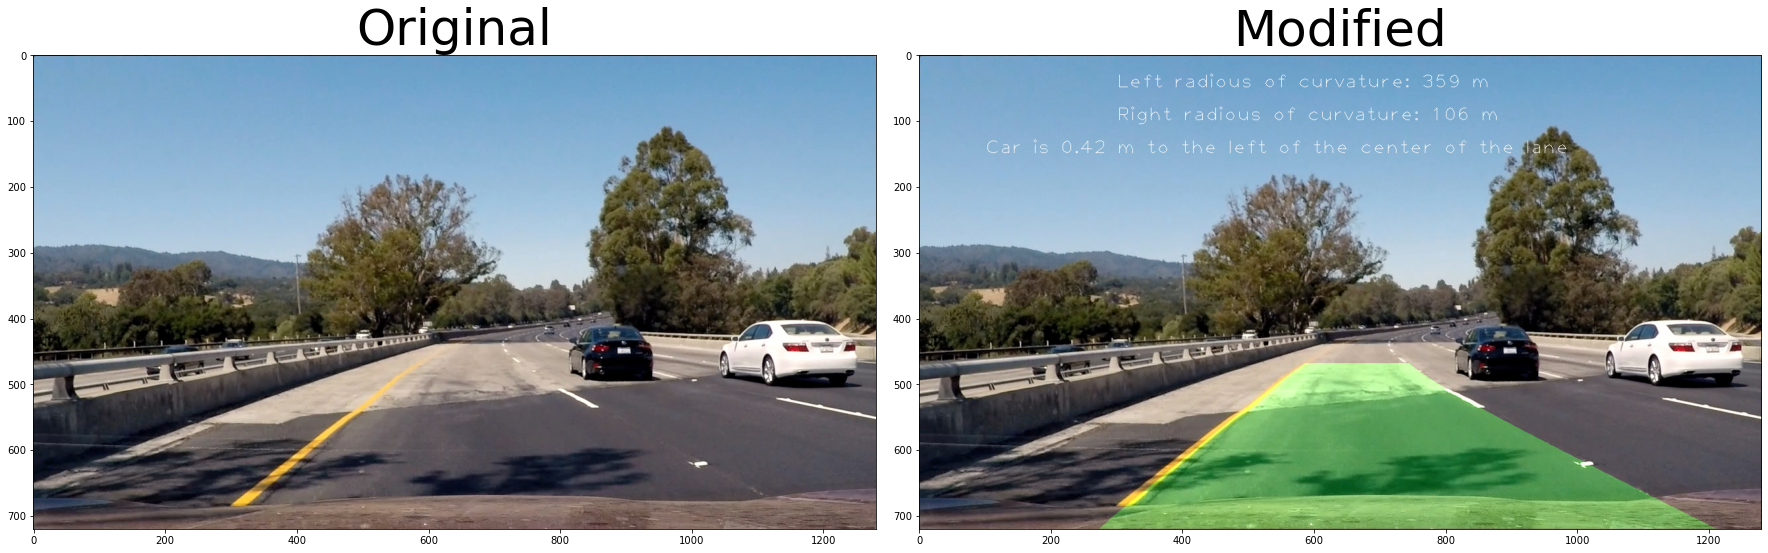

In [11]:
image = mpimg.imread('test_images/test4.jpg')
result = pipeline(image)
cal.compare_images(image, result, 0, None, 'RGB', 'RGB')

In [66]:
print(right_line.avefit)

[ 6.18484342e-05 -1.18226041e-01  3.68207951e+02]


In [67]:
result.shape

(720, 1280, 3)

In [68]:
print(left_line.exists)
print(right_line.exists)
print(left_line.wrong)
print(right_line.wrong)

True
True
1
1


In [85]:
print(left_line.fitlist)
print(right_line.fitlist)

[array([ 6.75116122e-05, -8.33772377e-02,  4.49989027e+02])]
[array([ 2.32662153e-04, -2.07904182e-01,  3.64006544e+02])]


## 5.2- Video project

### Initialize line

In [12]:
right_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

### Run on video

In [13]:
white_output = 'video_test_output_4.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_test_output_4.mp4.
Moviepy - Writing video video_test_output_4.mp4



Moviepy - Done !
Moviepy - video ready video_test_output_4.mp4
Wall time: 26min 54s


In [50]:
print(right_line.px)
print(right_line.py)
print(left_line.px)
print(left_line.py)
print(left_line.exists)
print(right_line.exists)

[296 297 298 ... 358 359 360]
[560 560 560 ...  79  79  79]
[]
[]
False
True


## 5.3- Challenge video

### Initialize line

In [14]:
right_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

### Run on video

In [15]:
white_output = 'video_challenge_test_output_3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_challenge_test_output_3.mp4.
Moviepy - Writing video video_challenge_test_output_3.mp4



Moviepy - Done !
Moviepy - video ready video_challenge_test_output_3.mp4
Wall time: 26min 59s


In [72]:
left_line.fitlist

[]

## 5.4- Harder challenge video

### Initialize line

In [16]:
right_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

In [17]:
white_output = 'video_hard_challenge_test_output_1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_hard_challenge_test_output_1.mp4.
Moviepy - Writing video video_hard_challenge_test_output_1.mp4



Moviepy - Done !
Moviepy - video ready video_hard_challenge_test_output_1.mp4
Wall time: 52min 1s
